# **Crime in San Fransico Doesn't Always Occur at Night**
**30 August 2023**

You would perhaps think many crimes tend to happen at night when less people are around to witness the act. However, as it turns out, that's not always a criminal's preferred time of day. In this notebook, 12 months of incident report data between 1 June 2022 and 31 May 2023 from San Francisco's open data portal [https://data.sfgov.org](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) was analysed. The original brief called for an analysis of the same incident dataset, but of three months in 2014. Since that was nine years ago, and computing power has increased significantly since then, the author decided to widen the time period of analysis and use far more recent data.

Whilst there were a number of possible areas of investigation, this analysis focussed on time of day patterns. This included determining when most crimes tended to occur and a more granular breakdown by crime type. The key finding from this analysis was that over a 24 hour period, the majority of crime actually occurred at midday (7.1%) followed by 6pm and 5pm (both 5.9%). Around 5.6% of crime occurred at midnight.

In [1]:
# import all necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.api.types import CategoricalDtype

In [2]:
incidents = pd.read_csv('sf_incidents_2223.csv')
# clean up the column names
incidents.columns = incidents.columns.str.lower().str.replace(' ', '_')
incidents.columns = incidents.columns.str.replace('incident_', '')
# select the columns for analysis
incidents = incidents.loc[:, ['row_id', 'datetime', 'date', 'time', 'code', 'category', 'subcategory', 'description']]

# convert datetime from an object to datetime type
incidents['datetime'] = pd.to_datetime(incidents.datetime, infer_datetime_format = True)
incidents['date'] = pd.to_datetime(incidents.date, infer_datetime_format = True)

# add hour information
incidents['hour_num'] = incidents.datetime.dt.hour
hour_dict = {0: '0 AM',
             1: '1 AM',
             2: '2 AM',
             3: '3 AM',
             4: '4 AM',
             5: '5 AM',
             6: '6 AM',
             7: '7 AM',
             8: '8 AM',
             9: '9 AM',
             10: '10 AM',
             11: '11 AM',
             12: '12 PM',
             13: '1 PM',
             14: '2 PM',
             15: '3 PM',
             16: '4 PM',
             17: '5 PM',
             18: '6 PM',
             19: '7 PM',
             20: '8 PM',
             21: '9 PM',
             22: '10 PM',
             23: '11 PM'}
incidents['hour'] = incidents.hour_num.map(hour_dict)
cat_type = CategoricalDtype(categories=['0 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM',
                                        '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM',
                                        '2 PM', '3 PM', '4 PM', '5 PM',  '6 PM', '7 PM',
                                        '8 PM', '9 PM', '10 PM', '11 PM'], ordered=True)
incidents.hour = incidents.hour.astype(cat_type)

# add time of day information
incidents['time_of_day'] = np.where(incidents.hour_num < 4, '12AM - 3AM',
                            np.where((incidents.hour_num >= 4) & (incidents.hour_num < 8), '4AM - 7AM',
                            np.where((incidents.hour_num >= 8) & (incidents.hour_num < 12), '8AM - 11AM',
                            np.where((incidents.hour_num >= 12) & (incidents.hour_num < 16), '12PM - 3PM',
                            np.where((incidents.hour_num >= 16) & (incidents.hour_num < 20), '4PM - 7PM',
                            np.where(incidents.hour_num >= 20, '8PM - 11PM', 'TBC'))))))
cat_type = CategoricalDtype(categories=["12AM - 3AM", "4AM - 7AM", "8AM - 11AM", "12PM - 3PM",
                                        "4PM - 7PM", "8PM - 11PM"], ordered=True)
incidents.time_of_day = incidents.time_of_day.astype(cat_type)

incidents['time_of_day2'] = np.where(incidents.hour_num < 5, 'night',
                            np.where((incidents.hour_num >= 5) & (incidents.hour_num < 8), 'early morning',
                            np.where((incidents.hour_num >= 8) & (incidents.hour_num < 11), 'morning',
                            np.where((incidents.hour_num >= 11) & (incidents.hour_num < 12), 'late morning',
                            np.where((incidents.hour_num >= 12) & (incidents.hour_num < 15), 'early afternoon',
                            np.where((incidents.hour_num >= 15) & (incidents.hour_num < 16), 'afternoon',
                            np.where((incidents.hour_num >= 16) & (incidents.hour_num < 17), 'late afternoon',
                            np.where((incidents.hour_num >= 17) & (incidents.hour_num < 19), 'early evening',
                            np.where((incidents.hour_num >= 19) & (incidents.hour_num < 21), 'evening',
                            np.where(incidents.hour_num >= 21, 'night', 'TBC'))))))))))
cat_type = CategoricalDtype(categories=["early morning", "morning", "late morning", "early afternoon",
                                        "afternoon", "late afternoon", "early evening", "evening",
                                        "night"], ordered=True)
incidents.time_of_day2 = incidents.time_of_day2.astype(cat_type)

# clean up the incident categories
incidents['category_semiclean'] = np.where(incidents.category == 'Other Miscellaneous', 'Other',
                                  np.where(incidents.category == 'Motor Vehicle Theft?', 'Motor Vehicle Theft',
                                  np.where(incidents.category == 'Human Trafficking (A), Commercial Sex Acts', 'Human Trafficking, Commercial Sex Acts',
                                  np.where(incidents.category == 'Weapons Offence', 'Weapons Offense',
                                  np.where(incidents.category == 'Suspicious', 'Suspicious Occ',
                                           incidents.category)))))

# collapse the primary categories into something useful
incidents.category_semiclean.value_counts()
incidents['category_clean'] = np.where(incidents.category_semiclean == 'Larceny Theft', 'Larceny/Theft',
                              np.where(incidents.category_semiclean == 'Malicious Mischief', 'Malicious Mischief/Damage',
                              np.where(incidents.category_semiclean == 'Motor Vehicle Theft', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Recovered Vehicle', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Drug Offense', 'Drug/Narcotics-Related',
                              np.where(incidents.category_semiclean == 'Weapons Offense', 'Weapons-Related',
                              np.where(incidents.category_semiclean == 'Traffic Violation Arrest', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Weapons Carrying Etc', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Stolen Property', 'Larceny/Theft',
                              np.where(incidents.category_semiclean == 'Courtesy Report', 'Non-Criminal',
                              np.where(incidents.category_semiclean == 'Case Closure', 'Non-Criminal',
                              np.where(incidents.category_semiclean == 'Vandalism', 'Malicious Mischief/Damage',
                              np.where(incidents.category_semiclean == 'Traffic Collision', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Forgery And Counterfeiting', 'Fraud',
                              np.where(incidents.category_semiclean == 'Fire Report', 'Arson',
                              np.where(incidents.category_semiclean == 'Embezzlement', 'Fraud',
                              np.where(incidents.category_semiclean == 'Sex Offense', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Vehicle Impounded', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Vehicle Misplaced', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Drug Violation', 'Drug/Narcotics-Related',
                              np.where(incidents.category_semiclean == 'Prostitution', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Rape', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Human Trafficking, Commercial Sex Acts', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Lost Property', 'Larceny/Theft',
                              np.where(incidents.category_semiclean == 'Suspicious Occ', 'Suspicious Occurrence',
                              np.where(incidents.category_semiclean == 'Offences Against The Family And Children', 'Domestic Violence',
                              np.where(incidents.category_semiclean == 'Gambling', 'Other',
                              np.where(incidents.category_semiclean == 'Civil Sidewalks', 'Other',
                                       incidents.category_semiclean))))))))))))))))))))))))))))

# incidents.category_clean.value_counts()
# incidents.info()

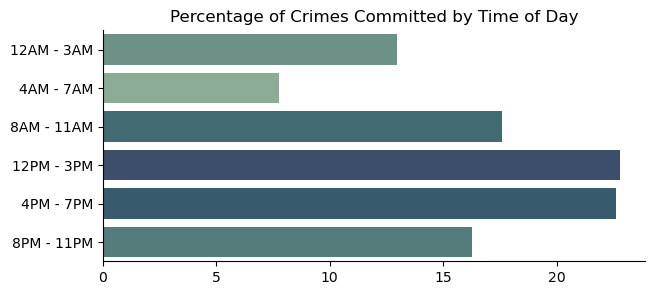

In [3]:
by_tod = pd.DataFrame(incidents.time_of_day.value_counts(normalize=True)).reset_index()
by_tod.time_of_day = by_tod.time_of_day * 100
by_tod.sort_values(by='index', inplace=True)

values = by_tod.time_of_day
custom_palette = sns.color_palette("crest", len(values))
colour_mapping = dict(zip(sorted(values), custom_palette))
colour_mapping

fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(data=by_tod, x='time_of_day', y='index',
            palette=[colour_mapping[val] for val in values], saturation=0.5)
ax.set(title='Percentage of Crimes Committed by Time of Day',
       xlabel = None,
       ylabel = None)
sns.despine()

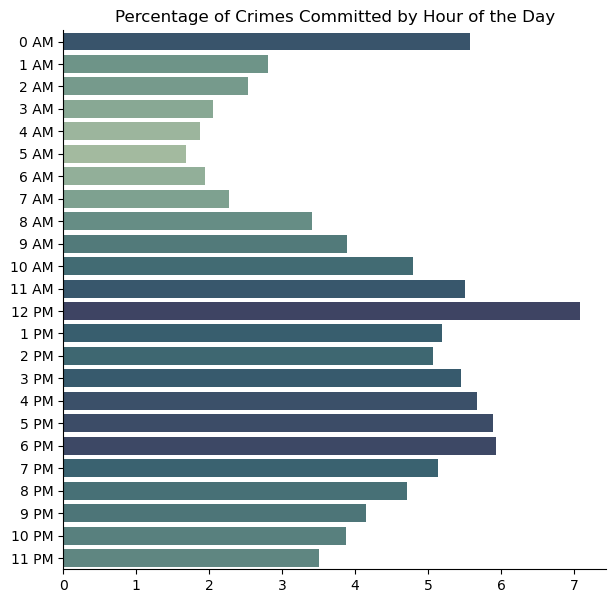

In [4]:
by_hour = pd.DataFrame(incidents.hour.value_counts(normalize=True)).reset_index()
by_hour.hour = by_hour.hour*100
by_hour.sort_values(by='index', inplace=True)

values = by_hour.hour
custom_palette = sns.color_palette("crest", len(values))
colour_mapping = dict(zip(sorted(values), custom_palette))
colour_mapping

fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(data=by_hour, x='hour', y='index',
            palette=[colour_mapping[val] for val in values], 
            saturation=0.5, orient='h')
ax.set(title='Percentage of Crimes Committed by Hour of the Day',
       xlabel = None,
       ylabel = None)
sns.despine()

In terms of the types of crime committed, Larceny/Theft was most common (34% of all crime) followed by motor-vehicle related crime (12.4%). Malicious mischief/damage (such as vandalism) was a distant third at 7.0%.

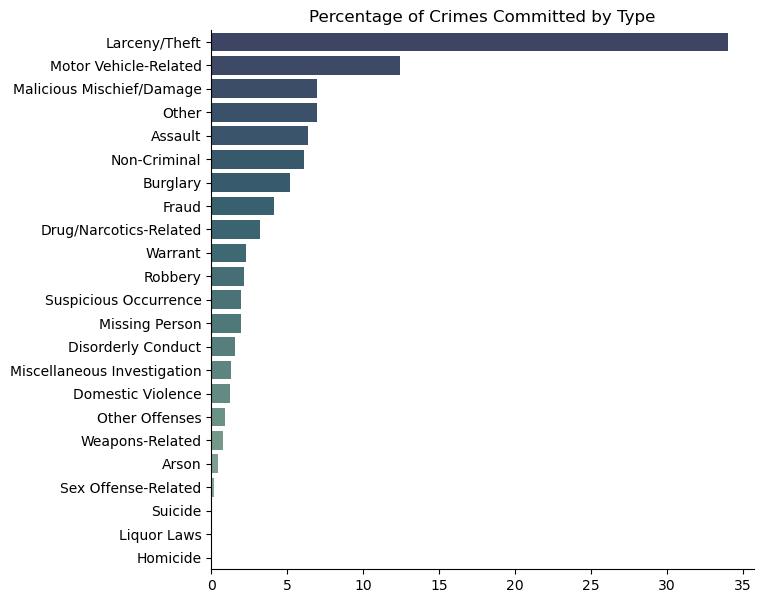

In [5]:
by_type = pd.DataFrame(incidents.category_clean.value_counts(normalize=True)).reset_index()
by_type.category_clean = by_type.category_clean*100
by_type.sort_values(by='category_clean', inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(data=by_type, x='category_clean', y='index',
            palette='crest_r', 
            saturation=0.5, orient='h')
ax.set(title='Percentage of Crimes Committed by Type',
       xlabel = None,
       ylabel = None)
sns.despine()

The following chart presents the proportion of crime types by time of day broadbands. It indicates that whilst there are a lot of similarities in the profiles, there are some differences in when different types of crime are more/less likely to occur. For example,
- about 50% of arson-related crime occurred between the hours of midnight and 8am
- just over 40% of burglery also ocurred in those early hours of the morning
- most drug/narcotics-related crime occurred in the afternoon/evening from midday to 8pm
- fraud peaked between midnight and 4am, and
- liquor law crime occurred predominently from midday to 8pm.

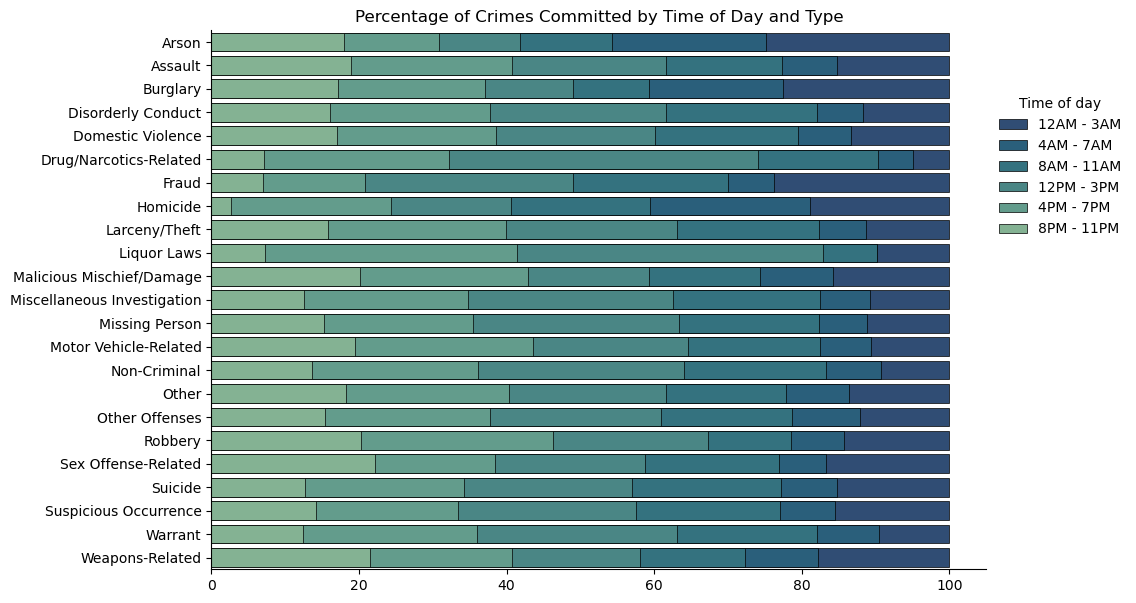

In [6]:
by_type_tod = pd.DataFrame(incidents[['category_clean', 'time_of_day']].value_counts()).reset_index()
by_type_tod.columns = ['category', 'time_of_day', 'count']
by_type = pd.DataFrame(incidents.category_clean.value_counts()).reset_index()
by_type.columns = ['category', 'category_total']
by_type_tod = by_type_tod.set_index('category').join(by_type.set_index('category')).reset_index()
by_type_tod['prop'] = by_type_tod['count'] / by_type_tod['category_total'] * 100
by_type_tod = by_type_tod.pivot(columns='time_of_day', index='category', values='prop')
by_type_tod.fillna(0, inplace=True)

custom_palette = sns.color_palette('crest_r')

fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=by_type_tod.iloc[:,::-1].cumsum(axis=1).stack().reset_index(name='prop'),
            x='prop', y='category', hue='time_of_day',
            hue_order = by_type_tod.columns, palette=custom_palette, edgecolor="black", linewidth=0.5,
            dodge=False)

ax.legend(bbox_to_anchor=(1.0, 0.9),
          title='Time of day', loc="upper left", frameon=False)
ax.set(title='Percentage of Crimes Committed by Time of Day and Type',
       xlabel = None,
       ylabel = None)
sns.despine()

In [7]:
# by_tod_type = pd.DataFrame(incidents[['time_of_day','category_clean']].value_counts()).reset_index()
# by_tod_type.columns = ['time_of_day', 'category', 'count']
# by_tod = pd.DataFrame(incidents.time_of_day.value_counts()).reset_index()
# by_tod.columns = ['time_of_day', 'tod_total']
# by_tod_type = by_tod_type.set_index('time_of_day').join(by_tod.set_index('time_of_day')).reset_index()
# by_tod_type['prop'] = by_tod_type['count'] / by_tod_type['tod_total'] * 100
# by_tod_type = by_tod_type.pivot(columns='category', index='time_of_day', values='prop')
# by_tod_type.fillna(0, inplace=True)

# sorted_cols = by_tod_type.iloc[0].sort_values(ascending=True).index
# by_tod_type = by_tod_type[sorted_cols]

# custom_palette = sns.color_palette('crest_r')

# fig, ax = plt.subplots(figsize=(10,5))
# sns.barplot(data=by_tod_type.iloc[:,::-1].cumsum(axis=1).stack().reset_index(name='prop'),
#             x='prop', y='time_of_day', hue='category',
#             hue_order = by_tod_type.columns, palette=custom_palette, edgecolor="black", linewidth=0.5,
#             dodge=False)

# legend_handles, legend_labels = ax.get_legend_handles_labels()
# legend_handles.reverse()
# legend_labels.reverse()

# ax.legend(legend_handles, legend_labels, bbox_to_anchor=(1.0, 1.05),
#           title='Crime type', loc="upper left", frameon=False)
# ax.set(title='Percentage of Crimes Committed by Time of Day and Type',
#        xlabel = None,
#        ylabel = None)
# sns.despine()